# Big Traces

This notebook is more optimized for handling large traces and focuses on easy to compute plots and metrics.

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pathlib
import matplotlib
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
import statistics
from sortedcontainers import SortedList, SortedDict
import time
from scipy import stats
import pprint
from functools import total_ordering
from numba import jit
#import bokeh
from bokeh.palettes import Pastel1
from dataclasses import dataclass
from sklearn.linear_model import LinearRegression

In [372]:
DATA_DIR = 'parrot-traces/medium-100ms-manualpd//'

In [153]:
FILES    = [p.absolute() for p in pathlib.Path(DATA_DIR).iterdir()]

@total_ordering
class trace:
    def __init__(self, path):
        self.path = path
        self.name = path.stem.split('_')[2]
        self.data = None
    def _load(self):
        return pd.read_csv(self.path, delim_whitespace=True)
    def load(self, persist=False):
        if self.data is not None:
            return self.data
        if persist:
            self.data = self._load()
            return self.data
        return self._load()
    def unload(self):
        self.data = None
    def loadLat(self):
        return np.array(pd.read_csv(self.path, delim_whitespace=True)['latency_nano'])
    def __repr__(self):
        return self.name
    def __lt__(self, obj):
        return ((self.name) < (obj.name))
    def __eq__(self, obj):
        return (self.name == obj.name)
    
TRACES  = sorted([trace(f) for f in FILES])

def loadAll():
    [t.load(persist=True) for t in TRACES]
    
def unloadAll():
    [t.unload() for t in TRACES]

In [154]:
print('Directory:'.ljust(10), DATA_DIR)
print('Files:'.ljust(10), *TRACES)

Directory: parrot-traces/medium-100ms-manualpd//
Files:     2mm 3mm adi atax bicg cholesky correlation covariance deriche doitgen durbin fdtd-2d floyd-warshall gemm gemver gesummv gramschmidt heat-3d jacobi-1d jacobi-2d lu ludcmp mvt nussinov seidel-2d symm syr2k syrk trisolv trmm


In [7]:
a = TRACES[3].loadLat()

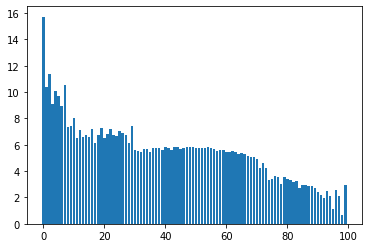

In [8]:
his,_ = np.histogram(a,bins=100)
np.seterr(divide = 'ignore')
fig, ax = plt.subplots()
#ax.hist(a[a>4], bins=100)
ax.bar([*range(len(his))],np.log(his))
plt.show()

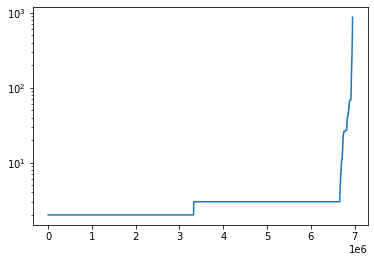

In [9]:
fig, ax = plt.subplots()
ax.semilogy(sorted(a))

In [10]:
#ss = len(str(len(a)))+2
#print(*[label.ljust(ss) for label in ['len', '<3']])
#print(*[str(datapoint).ljust(ss) for datapoint in [len(a), len(a[a<3]), len(a[a<3])/len(a)*100]])

print(f'Length: {len(a)}')
print(f'% < 3 : {len(a[a<3])/len(a):.2f}')
print(f'% < 4 : {len(a[a<4])/len(a):.2f}')
print(f'% < 5 : {len(a[a<5])/len(a):.2f}')

print(f'% < 6 : {len(a[a<6])/len(a):.2f}')
print(f'% < 7 : {len(a[a<7])/len(a):.2f}')
print(f'% < 8 : {len(a[a<8])/len(a):.2f}')


Length: 6954481
% < 3 : 0.48
% < 4 : 0.96
% < 5 : 0.96
% < 6 : 0.96
% < 7 : 0.96
% < 8 : 0.96


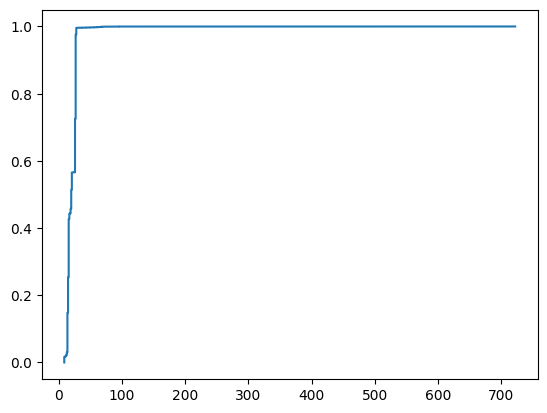

In [124]:
fig, ax = plt.subplots()
ecdf = ECDF(a[a>8])
ax.plot(ecdf.x, ecdf.y)
plt.show()

In [125]:
np.mean(a)

3.620457017787275

In [126]:
np.mean(np.random.choice(a, 1000000))

3.61458

In [132]:
tr = TRACES[0:2]

for t in tr:
    print(max(t.load()['phase']))

1
1


In [131]:
TRACES[0].load().columns

Index(['phase', 'rwf', 'threadID', 'addr', 'latency_nano'], dtype='object')

Overall: 4.89
Per-interval


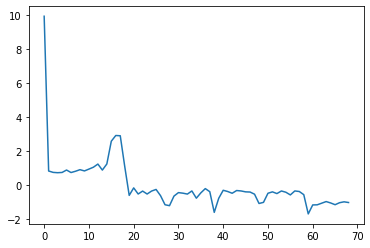

In [11]:
ov = np.mean(a)
print(f'Overall: {ov:.2f}')
print(f'Per-interval')

intlen = 100000
intervals = len(a)//intlen
peri = [np.mean(a[i*intlen : (i+1)*intlen]) for i in range(intervals)]
#print(peri)

fig, ax = plt.subplots()
#ax.plot(peri)
#ax.hlines(y=ov, xmin=0, xmax=intervals, linewidth=2, color='r')

# Error plot
ax.plot(peri-ov)

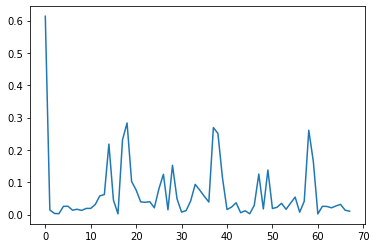

In [15]:
def abspctchange(old, new):
    return np.abs((old - new) / old)
pc = [abspctchange(peri[i], peri[i+1]) for i in range(len(peri)-1)]
#print(np.array(pc) < 0.05)
plt.plot(pc) 
plt.show()

1.0

In [174]:
print(TRACES[3])

durbin


In [202]:
def get_phase_changes(phases):
    pc = []
    for i in range(len(phases)-1):
        if phases[i] != phases[i+1]:
            pc.append(i)
    return pc

def reformat_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    
    
@jit
def get_phase_changes(arr, interval_len):
    marker = 0
    #changes = {0:arr[0]}
    intervals = []
    for i in range(len(arr)-1):
        if arr[i] != arr[i+1]:
            intervals.append([marker, i//interval_len, arr[i]])
            marker = i//interval_len
    intervals.append([marker, i//interval_len, arr[-1]])
    return intervals

def pl_latency_over_time(ax, t, interval_len):
    #ov = np.mean(series)
    #print(f'loading {t.name}')
    df = t.load(persist=True)
    series = df['latency_nano']
    #print('doing get_phase_changes')
    #pc = get_phase_changes(df['phase'])
    #print(pc)
    #print(np.array(pc) // interval_len)
    nintervals = len(series)//interval_len
    peri = [np.mean(series[i*interval_len : (i+1)*interval_len]) for i in range(nintervals)]
    ax.plot(peri, color='black', markersize=1)
    ax.set_xticks([nintervals//2, nintervals])
    ax.text(nintervals//2, 15, t.name, ha='center')
    reformat_ax(ax)
    
    # Add background patch
    color = Pastel1[9] #['#daffd2', '#ffc5d3']
    intervals = get_phase_changes(np.array(df['phase']), interval_len)
    #ii = 0
    for start, end, phase in intervals:
        rectangle = matplotlib.patches.Rectangle((start, 0), end - start, 15, facecolor=color[phase%len(color)])
        ax.add_patch(rectangle)
        #ii+=1
    

#fig, axs = plt.subplots(ncols=len(TRACES), sharey=True)
#for i, t in enumerate(TRACES[:1]):
#    pl_latency_over_time(axs[i], t, 100000)

#fig.set_size_inches((2*len(TRACES), 2))
#plt.show()

In [169]:
class Mapper:
    def __init__(self, size):
        self.size = size
        self.smallest_sq = int(np.ceil(np.sqrt(self.size)))
        
        # There will never be a non-full first row
        self.ncols = self.smallest_sq
        
        # If the last row would be completely empty, reduce this number
        # Only need enough rows to fit up to size elements
        self.nrows = int(np.ceil(self.size / self.ncols))
        
        self.fig, self.ax = plt.subplots(nrows = self.nrows, ncols=self.ncols, sharey=True)

    def get_remainder(self):
        # Any spots that wouldn't be full go here
        return [self[i] for i in range(self.size, self.nrows*self.ncols)]
    
    def __getitem__(self, idx):
        if idx >= self.size:
            raise IndexError(f'Requested index ({idx}) outside configured range (0-{self.size-1}).')
        return self.ax[(idx//self.smallest_sq, idx % self.smallest_sq)]
    


In [155]:
%%time
loadAll()

CPU times: user 4min 42s, sys: 44.4 s, total: 5min 26s
Wall time: 5min 34s


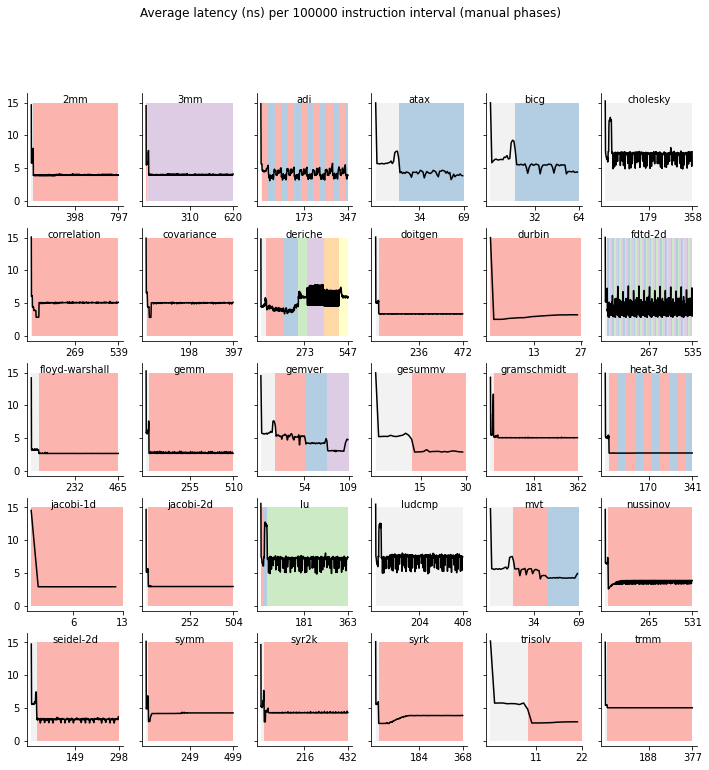

In [252]:
mapper = Mapper(len(TRACES))
fig = mapper.fig
#fig, axs = plt.subplots(nrows=remap.smallest_sq, ncols = remap.smallest_sq, sharey=True)

interval_len = 100000
for i, t in enumerate(TRACES):
    pl_latency_over_time(mapper[i], t, 100000)
fig.set_size_inches((2*remap.smallest_sq, 2*remap.smallest_sq))
fig.patch.set_facecolor('white')
fig.suptitle(f'Average latency (ns) per {interval_len} instruction interval (manual phases)')
plt.savefig(f'plots/mean-latency-per-interval-{interval_len}-2.png')
plt.show()

In [124]:
bokeh

[]

In [123]:
print(re.ncols, re.nrows)

6 6


In [201]:
for t in TRACES:
    print(f'{t.name}: {max(t.load()["phase"])}')

2mm: 0
3mm: 3
adi: 1
atax: 1
bicg: 1
cholesky: -1
correlation: 0
covariance: 0
deriche: 5
doitgen: 0
durbin: 0
fdtd-2d: 3
floyd-warshall: 0
gemm: 0
gemver: 3
gesummv: 0
gramschmidt: 0
heat-3d: 1
jacobi-1d: 0
jacobi-2d: 0
lu: 2
ludcmp: -1
mvt: 1
nussinov: 0
seidel-2d: 0
symm: 0
syr2k: 0
syrk: 0
trisolv: 0
trmm: 0


To be clear, the workflow is
1. identify phases with a PD-based phase detector
2. Confirm that we have reached a steady state and found a region we can model by checking that the 
mean latency is a stable distribution

In [144]:
def mean_by_interval(t, interval_len):
    nintervals = len(t)//interval_len
    return [np.mean(t[i*interval_len : (i+1)*interval_len]) for i in range(nintervals)]

t = TRACES[0]
lat = np.array(t.load()['latency_nano'])
lat_int = mean_by_interval(lat, interval_len)
#plt.plot(lat_int[100:])
print(f'Length of lat_int: {len(lat_int)}')

Length of lat_int: 581


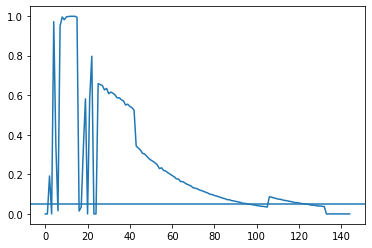

In [150]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, display=True):
    #print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if display:
        print (dfoutput)
    return float(dfoutput['p-value'])
# Call the function and run the test

#adf_test(lat_int[:20])

fig, ax = plt.subplots()
ax.plot([adf_test(lat_int[:i], False) for i in range(5,150)])   
ax.axhline(0.05)
plt.show()

In [142]:
adf_test(lat)

KeyboardInterrupt: 

In [178]:
%%time
aa = np.array(TRACES[0].load()['phase'])
print(get_phase_changes(aa, interval_len))

[[0, 18, -1], [18, 797, 0]]
CPU times: user 590 ms, sys: 115 ms, total: 706 ms
Wall time: 709 ms


In [193]:
from bokeh.palettes import Pastel1
Pastel1

{3: ('#fbb4ae', '#b3cde3', '#ccebc5'),
 4: ('#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4'),
 5: ('#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6'),
 6: ('#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc'),
 7: ('#fbb4ae',
  '#b3cde3',
  '#ccebc5',
  '#decbe4',
  '#fed9a6',
  '#ffffcc',
  '#e5d8bd'),
 8: ('#fbb4ae',
  '#b3cde3',
  '#ccebc5',
  '#decbe4',
  '#fed9a6',
  '#ffffcc',
  '#e5d8bd',
  '#fddaec'),
 9: ('#fbb4ae',
  '#b3cde3',
  '#ccebc5',
  '#decbe4',
  '#fed9a6',
  '#ffffcc',
  '#e5d8bd',
  '#fddaec',
  '#f2f2f2')}

In [304]:
f_conf = 0.05
window_start = 100
sf = 1 # shift factor (unit: windows)
gf = 1 # grow factor (unit: datapoints)


def f_test(group1, group2) -> (np.float64, np.float64):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-stats.f.cdf(f, nun, dun)
    return f, p_value

@dataclass
class window:
    data: np.ndarray
    start: int = 0
    size: int = 1000
        
    def get(self, idx):
        return range(self.start + self.size*idx, self.start + self.size + (self.size)*idx)

    def shift_and_grow(self,shift, grow):
        # shift units: how many windows to shift by
        # grow units: how many datapoints to grow by
        self.start += self.size * shift
        self.size  += grow
        

def ftPjRG(lat, window_start):
    
    max_shifts = len(lat) 
    win = window(size=window_start)
    _phase = 'ftest'
    
    while(True):
        
        if _phase == 'ftest':
            
        f_val, f_pv = f_test(lat[win.get(0)], lat[win.get(1)])
        # Null hypothesis: windows have same variance
        # Reject null: windows have different variance
    
        
        if f_pv < f_conf:
            print('shift window...')
            win.shift_and_grow(sf, gf)
        else:
            print('proceed to Phase 2...')
            t_val, t_pv = stats.ttest_ind(lat[win.get(0)], lat[win.get(1)])
            # Null: windows have same mean
            # Reject: windows have different mean
            
            print(t_val, t_pv)
            break      
        if win.get(1).stop >= len(lat):
            print('never converged!')
            break
    
    
    
ll = np.array(TRACES[6].load()['latency_nano'], dtype=np.int64)
ftPjRG(ll, window_start)

shift window...
proceed to Phase 2...
2.047783560882157 0.0418881860244464


In [ ]:
#@dataclass
#class ftpjrg_constants:
m_s = 10
r_t = 1
g_t = 1
t_conf = 0.05

proj_dist = 5
p_j = 1

proj_lim = 1
s_pj = 1
g_pj = 1

window_start = 1000


@dataclass
class window2:
    data: np.ndarray
    start: int = 0
    size: int = 1000
        
    def get(self, idx, debug=False):
        begin = self.start + self.size*idx
        end   = self.start + self.size + (self.size)*idx
        if debug:
            print(f'[start: {self.start}, size: {self.size}] -> [begin: {begin}, end: {end}]')
        if end > len(self.data):
            return None
        return self.data[range(begin, end)]
    
    def get_range(self, idx_begin, idx_end, debug=False):
        if idx_end - idx_begin < 1:
            return None
        
        begin = self.start + self.size*idx_begin
        end   = self.start + self.size + (self.size)*idx_end
        
        if debug:
            print(f'[start: {self.start}, size: {self.size}] -> [begin: {begin}, end: {end}]')
        if end > len(self.data):
            return None
        
        return self.data[range(begin, end)]
    
    def get_point(self, pt):
        return pt*self.size, self.data[pt*self.size]

    def shift_and_grow(self,shift, grow):
        # shift units: how many windows to shift by
        # grow units: how many datapoints to grow by
        self.start += self.size * shift
        self.size  += grow
        
    def shift_and_reset(self, shift, size):
        self.start += self.size * shift
        self.size = size

_phase = 1
def ftPjRG2(df, window_start, summarize):
    
    latency = np.array(df.load()['latency_nano'], dtype=np.int64)
    new_len = len(latency) // summarize
    latency_summarized = np.array([np.mean(latency[i*summarize : (i+1)*summarize]) for i in range(new_len)])
    win = window2(latency_summarized, size=window_start)
    
    win0 = None
    win1 = None
    m_s  = 10
    _phase = 1
    
    while(True):
        if _phase == 1:
            
            print('Phase 1!')
        
            # Update windows
            win0 = win.get(0)
            win1 = win.get(1)
        
            # If we have gone past the end of the input array, then we never reached a steady state
            if win0 is None or win1 is None:
                print('Never converged!')
                return None
        
            # f-test
            # Null hypothesis: windows have same variance
            # Reject null: windows have different variance
            f_val, f_pv = f_test(win0, win1)
            if f_pv < f_conf:
                win.shift_and_grow(sf, gf)
                
                if win.size < m_s*window_start:
                    continue
                else:
                    win.shift_and_reset(sf, window_start)
                    m_s = int(m_s * g_m)
            else:
                _phase = 2
                continue
                

        elif _phase == 2:
            print('Phase 2!')
            
            # Null: windows have same mean
            # Reject: windows have different mean
            t_val, t_pv = stats.ttest_ind(win0, win1)
            
            if t_val < t_conf:
                win.shift_and_grow(sf, gf)
                _phase = 1
                continue
            else:
                _phase = 3
                continue

            return 
        elif _phase == 3:
            print('Phase 3!')
            win_combo = win.get_range(0, 1)
            
            if win_combo is None:
                print('Never converged!')
                return None
            
            lm = LinearRegression()
            lm.fit(np.array(range(len(win_combo))).reshape(-1,1), win_combo.reshape(-1, 1))
            
            # lm.coef_, lm.intercept_
            
            
            x_star, y_true = win.get_point(proj_dist)
            y_hat = lm.intercept_ + lm.coef_*x_star
            y_hat = y_hat[0][0]
            
            if np.abs(y_hat - y_true) > proj_lim:
                win.shift_and_grow(s_pj, g_pj)
                _phase = 1
                continue
            
            return win.start
    
        else:
            print(f'Error - phase not recognized {_phase}')
            sys.exit(1)

Phase 1!
Phase 1!
Phase 1!
Phase 1!
Phase 2!
Phase 1!
Phase 1!
Phase 2!
Phase 3!


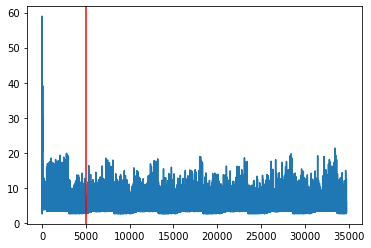

In [405]:
trace = TRACES[2]

stable = ftPjRG2(TRACES[6], window_start, 1000)

fig, ax = plt.subplots()
summarize = 1000
_ll = trace.load()['latency_nano']
new_len = len(_ll) // summarize

ll = np.array([np.mean(_ll[i*summarize : (i+1)*summarize]) for i in range(new_len)])
ax.plot(ll)
ax.axvline(stable, color='red')
fig.show()

In [392]:
ll = np.array(TRACES[6].load()['latency_nano'])
_win = window2(ll, size=window_start)
print(len(ll) // window_start)
print(len(_win.get(539545, debug=True)))

print(len(_win.get_range(0, 1, debug=True)))




539546
[start: 0, size: 100] -> [begin: 53954500, end: 53954600]
100
[start: 0, size: 100] -> [begin: 0, end: 200]
200


In [258]:
@jit
def select(arr, window, start, end):
    return arr[start*window:end*window]

def slope_test(lat, window, lag):
    nwindows = len(lat)//window
    slopes = []
    for i in range(nwindows-lag):
        st = stats.linregress([*range(lag*window)],select(lat, window, i, i+lag))
        slopes.append(st.slope)
    return slopes
        

ll = np.array(TRACES[6].load()['latency_nano'], dtype=np.int64)
slopes = slope_test(ll, 10000, 5)

In [248]:
sl = slopes[:40]
np.abs(sl)<0.000001

array([False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

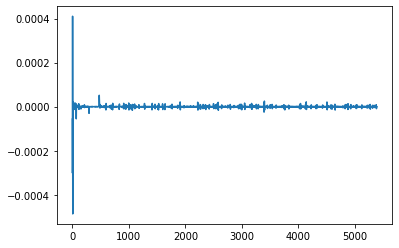

In [259]:
plt.plot(slopes)

In [264]:
def slope_plot(ax, t, interval_len):
    #ov = np.mean(series)
    #print(f'loading {t.name}')
    df = t.load(persist=True)
    series = df['latency_nano']

    nintervals = len(series)//interval_len
    slopes = slope_test(np.array(series), interval_len, 5)
    ax.plot(slopes, color='black', markersize=1)
    #ax.set_xticks([nintervals//2, nintervals])
    ax.text(nintervals//2, 15, t.name, ha='center')
    reformat_ax(ax)
    
    
    return
    # Add background patch - ISSUE: They are too tall
    color = Pastel1[9] #['#daffd2', '#ffc5d3']
    intervals = get_phase_changes(np.array(df['phase']), interval_len)

    #for start, end, phase in intervals:
    #    ax.axvline(start)
    #for start, end, phase in intervals:
    #    rectangle = matplotlib.patches.Rectangle((start, 0), end - start, 15, facecolor=color[phase%len(color)])
    #    ax.add_patch(rectangle)


In [265]:
mapper = Mapper(len(TRACES))
fig = mapper.fig
#fig, axs = plt.subplots(nrows=remap.smallest_sq, ncols = remap.smallest_sq, sharey=True)

interval_len = 100000
for i, t in enumerate(TRACES):
    slope_plot(mapper[i], t, 100000)
fig.set_size_inches((2*remap.smallest_sq, 2*remap.smallest_sq))
fig.patch.set_facecolor('white')
#fig.suptitle(f'Average latency (ns) per {interval_len} instruction interval (manual phases)')
#plt.savefig(f'plots/mean-latency-per-interval-{interval_len}-2.png')
plt.show()

ValueError: Image size of 705x38884464 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x864 with 30 Axes>

SyntaxError: invalid syntax (<ipython-input-305-2eb0ce13850d>, line 2)